<a href="https://colab.research.google.com/github/alexandr-khvatov/text_classification/blob/main/model/Navec_BiLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pymorphy2 --quiet
!pip install navec --quiet
!pip install wget --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 KB 490.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 47.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [2]:
import wget
import os
import sys
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymorphy2
import sklearn
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from navec import Navec

# **Get cleaned dataset**

In [3]:
url = 'https://raw.githubusercontent.com/alexandr-khvatov/text_classification/main/data/data_cleaned_RU.csv'

PATH_CLEANED_DATASET = 'data_cleaned_RU.csv'
if not os.path.exists(PATH_CLEANED_DATASET):
    wget.download(url)

**Parse**

In [4]:
df = pd.read_csv(PATH_CLEANED_DATASET)
df=df.astype({'toxic': 'int64'})
df.sample(10)

,comment,toxic
13944,жидо холоп закукарекать,1
10130,пустить козёл огород,1
1591,таки как это представить я аж кипа голова слететь,0
11489,ербанк коффф для ты ты подобный приготовить от...,1
13286,а вы офицер рот вы ебал охфицер,1
331,быдло вообще запретить рассуждать оно должный ...,1
11802,георгий простить но ты съезжать,1
4808,если отлетать сам бетон то нет если же стена о...,0
12031,очень круто пока не знать как привлечь аудитор...,0
4042,у мы уже больничка перевести на баланс одминис...,0


In [5]:
print("max :",df.comment.str.len().max())
print("min :",df.comment.str.len().min())
print("mean :",df.comment.str.len().mean())

max : 6728
min : 1
mean : 159.97800444074383


max:  890
min:  0
mean:  24.667291146267


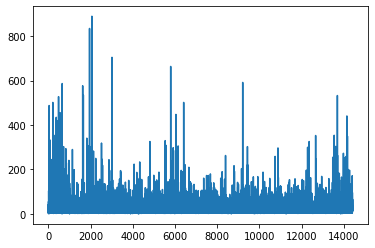

In [6]:
import statistics

print("max: ",max(list(map(lambda comment: len(comment.split()),df.comment))))
print("min: ",min(list(map(lambda comment: len(comment.split()),df.comment))))
print("mean: ",statistics.mean(list(map(lambda comment: len(comment.split()),df.comment))))
plt.plot(df.comment.index,list(map(lambda comment: len(comment.split()),df.comment)))

In [7]:
sentences = df.comment.values
labels = df.toxic.values

**Split**

In [8]:
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=.2, random_state=42)   # .15  .2
print(X_train.shape)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.25, random_state=42) # .1764705882352941   .25

In [9]:
X_train.shape

(11529,)

In [10]:
type(X_train)

numpy.ndarray

In [11]:
from navec import Navec

url = 'https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar'
PATH_NAVEC = 'navec_hudlit_v1_12B_500K_300d_100q.tar'

if not os.path.exists(PATH_NAVEC):
    wget.download(url)
navec = Navec.load(PATH_NAVEC)

In [12]:
NAVEC_UNK= '<unk>'
NAVEC_PAD= '<pad>'
DIMENSION_EMBEDDING=navec.get('<unk>').shape[0]

In [13]:
def vectorize_sentence(sentence: str, vectorizer=navec,unc_token =NAVEC_UNK, pad_token = NAVEC_PAD, max_sequence_length=30) -> np.array:
    tokens = sentence.split()
    embedd_tokens = [navec.get(t, navec[unc_token]) for t in tokens[:max_sequence_length]]
    if len(embedd_tokens) < max_sequence_length:
        embedd_tokens += [navec[pad_token]] * (max_sequence_length - len(embedd_tokens))
    return np.array(embedd_tokens)

In [14]:
# получить длину(количество слов) отзывов в 75% датасета
sequence_length=int(round(np.percentile(list(map(lambda sentence: len(sentence.split()), X_train)), 75)))

In [15]:
sequence_length

28

In [16]:
navec.get('<unk>').shape[0]

300

In [17]:
X_train = np.array(list(map(
    lambda sentence:vectorize_sentence(
        sentence,
        vectorizer=navec,
        unc_token =NAVEC_UNK,
        pad_token = NAVEC_PAD,
        max_sequence_length=sequence_length),
    X_train.flatten()
    )
))

X_val = np.array(list(map(
    lambda sentence:vectorize_sentence(
        sentence,
        vectorizer=navec,
        unc_token =NAVEC_UNK,
        pad_token = NAVEC_PAD,
        max_sequence_length=sequence_length),
    X_val.flatten()
    )
))

X_test = np.array(list(map(
    lambda sentence:vectorize_sentence(
        sentence,
        vectorizer=navec,
        unc_token =NAVEC_UNK,
        pad_token = NAVEC_PAD,
        max_sequence_length=sequence_length),
    X_test.flatten()
    )
))


In [18]:
X_train.shape

(11529, 28, 300)

**Build RNN model**

Model: "Glove-Navec_BiLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 spatial_dropout1d (SpatialD  (None, 28, 300)          0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 28, 512)          1140736   
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 512)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                

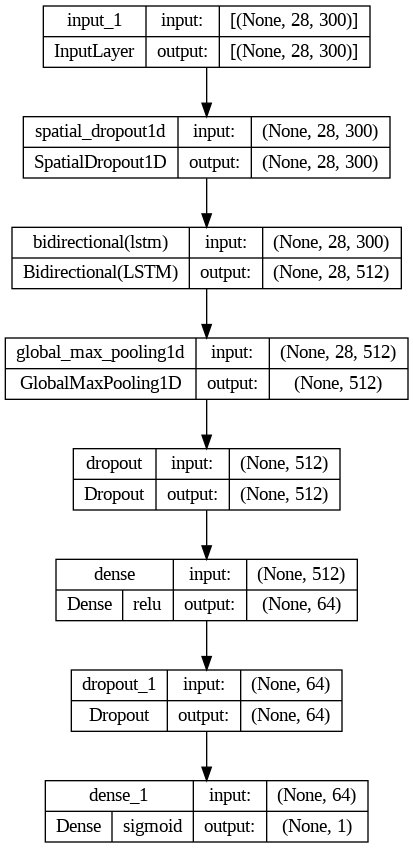

In [19]:
import tensorflow as tf
from tensorflow.keras.metrics import TruePositives,FalsePositives,TrueNegatives,FalseNegatives,BinaryAccuracy,Precision,Recall,AUC,AUC
from tensorflow.keras import Sequential,losses
from tensorflow.keras.layers import Input, Dense, Dropout,Bidirectional,LSTM,GlobalMaxPool1D,SpatialDropout1D
from tensorflow.keras.utils import plot_model

METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
      AUC(name='prc', curve='PR'), # precision-recall curve
]

SEED = 42
SPLIT = 0.2
EPOCHS = 20
BATCH_SIZE = 512
MODEL_NAME = 'Glove-Navec_BiLSTM'

negative_count, neutral_count = np.bincount(y_train)

initial_output_bias = tf.keras.initializers.Constant(
    np.log([neutral_count/negative_count])
)

model = tf.keras.Sequential(
    [
    Input(shape=(sequence_length, DIMENSION_EMBEDDING,),dtype=tf.float32),
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(256, recurrent_dropout=0.1, return_sequences=True)),
    GlobalMaxPool1D(),
    Dropout(rate=0.5, seed=SEED),
    Dense(64, activation='relu'),
    Dropout(rate=0.5, seed=SEED),
    Dense(1,bias_initializer=initial_output_bias,activation='sigmoid'),
]
,name=MODEL_NAME)

model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=METRICS
)
model.summary()

plot_model(model,
           to_file='model.png',
           show_shapes=True,
           show_layer_names=True,
           layer_range=None,
            show_layer_activations=True)

In [20]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

def calculate_weights(pos_count, neg_count):
    total = pos_count + neg_count
    return {
        0: (1 / neg_count) * total / 2.0,
        1: (1 / pos_count) * total / 2.0
    }

history = model.fit(
    x=X_train,
    y=y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val,y_val),
    callbacks=[early_stopping],
    class_weight=calculate_weights(neutral_count, negative_count),
)

Epoch 1/20
19/19 [==============================] - 16s 288ms/step - loss: 0.5385 - tp: 1963.0000 - fp: 1012.0000 - tn: 5075.0000 - fn: 1173.0000 - accuracy: 0.7631 - precision: 0.6598 - recall: 0.6260 - auc: 0.8124 - prc: 0.7082 - val_loss: 0.3358 - val_tp: 569.0000 - val_fp: 138.0000 - val_tn: 1417.0000 - val_fn: 182.0000 - val_accuracy: 0.8612 - val_precision: 0.8048 - val_recall: 0.7577 - val_auc: 0.9200 - val_prc: 0.8553
Epoch 2/20
19/19 [==============================] - 5s 284ms/step - loss: 0.3635 - tp: 2641.0000 - fp: 772.0000 - tn: 5315.0000 - fn: 495.0000 - accuracy: 0.8626 - precision: 0.7738 - recall: 0.8422 - auc: 0.9201 - prc: 0.8556 - val_loss: 0.3122 - val_tp: 562.0000 - val_fp: 106.0000 - val_tn: 1449.0000 - val_fn: 189.0000 - val_accuracy: 0.8721 - val_precision: 0.8413 - val_recall: 0.7483 - val_auc: 0.9347 - val_prc: 0.8757
Epoch 3/20
19/19 [==============================] - 4s 227ms/step - loss: 0.3207 - tp: 2733.0000 - fp: 736.0000 - tn: 5351.0000 - fn: 403.0000 

**Save model**

In [21]:
model.save(MODEL_NAME)

In [22]:
pred = model.predict(X_test).flatten()

91/91 [==============================] - 2s 22ms/step


In [23]:
pred

array([0.9974311 , 0.0014653 , 0.00845953, ..., 0.9933863 , 0.993547  ,
       0.00319569], dtype=float32)

In [24]:
pred

array([0.9974311 , 0.0014653 , 0.00845953, ..., 0.9933863 , 0.993547  ,
       0.00319569], dtype=float32)

In [25]:
threshold =0.5
pred = np.where(pred<threshold,0,1)

In [26]:
pred

array([1, 0, 0, ..., 1, 1, 0])

In [27]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.rcParams.update({'font.size': 22})
  plt.figure(figsize=(7,7))
  sns.heatmap(cm, annot=True, fmt="d",cmap='PuBu')
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  print("Accuracy: {0:.2f} %".format(100 * accuracy_score(y_test, pred)))
  print("Recall: {0:.2f} %".format(100 * recall_score(y_test, pred)))
  print("Precision: {0:.2f} %".format(100 * precision_score(y_test, pred)))
  print("F1-score: {0:.2f} % \n".format(100 * f1_score(y_test, pred)))
  precision, recall, f1score = precision_recall_fscore_support(y_test, pred, average='macro')[:3]
  print(f'precision: {precision}, recall: {recall}, f1score: {f1score}')
  print(classification_report(y_test, pred,digits=4))  
  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])

Accuracy: 90.36 %
Recall: 84.88 %
Precision: 85.42 %
F1-score: 85.15 % 

precision: 0.8907065710281145, recall: 0.889408222564062, f1score: 0.8900519207722597
              precision    recall  f1-score   support

           0     0.9272    0.9300    0.9286      1944
           1     0.8542    0.8488    0.8515       939

    accuracy                         0.9036      2883
   macro avg     0.8907    0.8894    0.8901      2883
weighted avg     0.9034    0.9036    0.9035      2883

True Negatives:  1808
False Positives:  136
False Negatives:  142
True Positives:  797


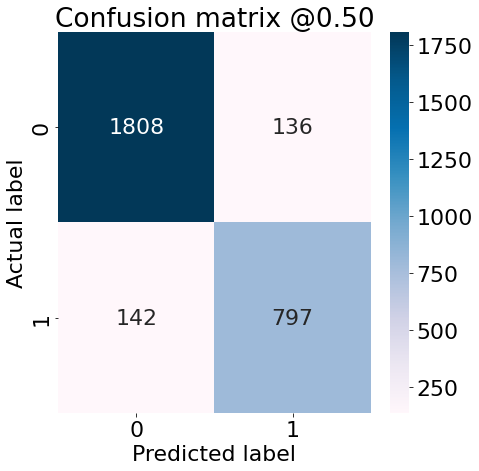

In [28]:
plot_cm(y_test, pred)

In [29]:
def plot_metrics(history):
  metrics = ['loss','accuracy', 'precision', 'recall','auc','prc']
  plt.figure(figsize=(20, 20), tight_layout={'h_pad': 3})
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(3,2,n+1)
    plt.plot(history.epoch, history.history[metric],  label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],label='Val')
    plt.xlabel('Epoch', fontdict={'fontsize': 15})
    plt.title(name, fontdict={'fontsize': 21, 'fontweight': 500}, pad=20)
    plt.legend(fontsize=21)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

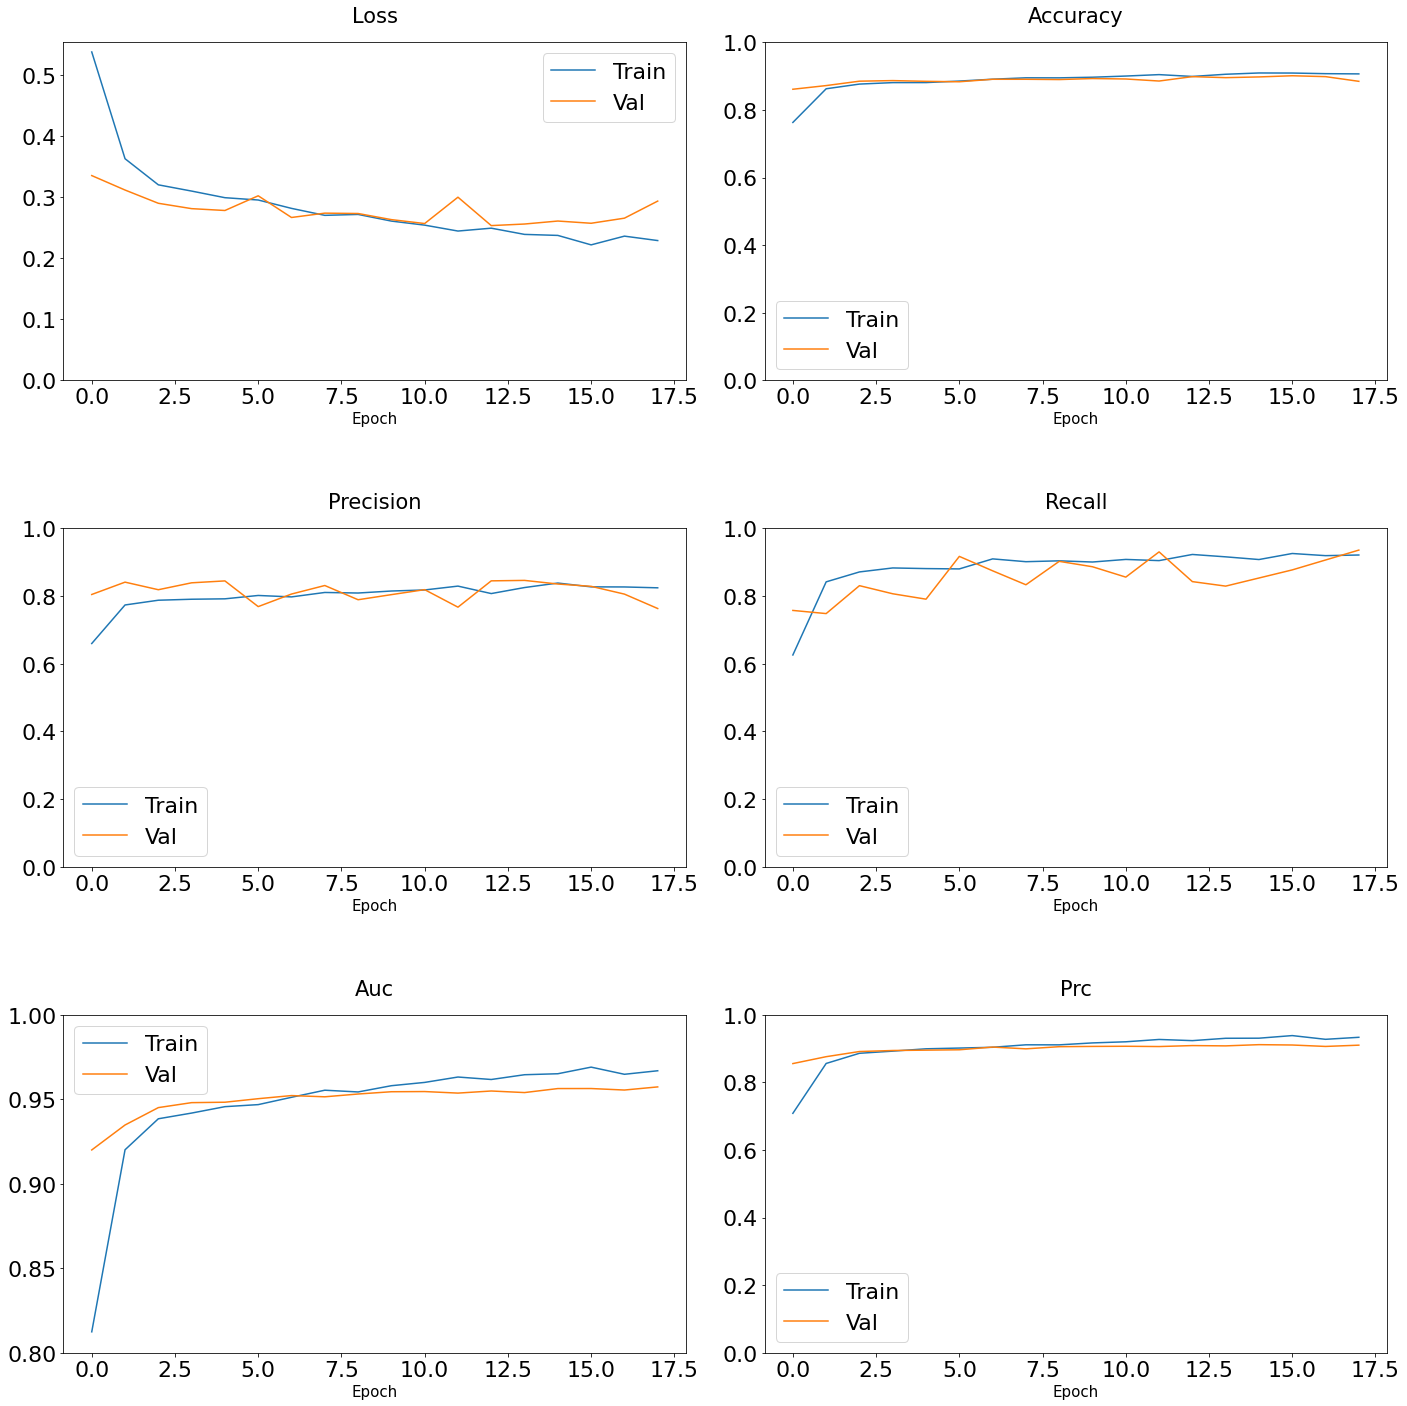

In [30]:
plot_metrics(history)